In [1]:
import numpy as np
import scipy.stats as ss
import elfi
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.examples import clinic
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

warning in stationary: failed to import cython module: falling back to numpy


# Clinic Example
![](img/clinic.png)

In [2]:
simulator = clinic.simulator

In [3]:
# Set the generating parameters that we will try to infer
lambda0 = 1/5

# Generate some dat9 (using a fixed seed here)
np.random.seed(1228)
y0 = simulator(lambda0)
print(y0)

[[93], array([  0.        ,   0.        ,   0.        ,   3.45527336,
         4.61291768,   1.29918025,   2.45140749,   0.23051393,
         0.        ,   0.        ,   6.26789611,  10.20161231,
        10.82411188,  13.71850785,  12.63887557,  15.05359447,
        19.82351101,  23.19141753,  10.60791924,  16.92525145,
         7.75719469,   0.        ,   7.01533479,   4.06564559,
         0.03777529,   1.0474774 ,   4.43689264,   2.36737128,
         3.87991674,   9.84017067,  12.89650214,  14.9624115 ,
         3.22822738,   6.17186024,   8.41587215,   5.61509602,
         9.57343099,   7.73240485,   6.44211711,  10.30399431,
        13.81556125,   0.        ,   0.        ,   0.        ,
         0.55332244,   5.37105957,   0.62420856,   6.81555322,
         2.94399467,   1.20860367,   0.        ,   0.        ,
         0.        ,   0.        ,   0.62942678,   0.68413813,
         1.58896581,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,

In [4]:
closing_time, nr_patients, nr_waiting_patients = clinic.summaries

In [5]:
# prior over rate parameter
rate = pyabc.Prior('uniform', 0.01,1, name='rate')
rate.name

'rate'

# Our PYABC

In [6]:
rej = pyabc.RejectionSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [7]:
rej.sample(nr_samples=10000, threshold=0.05)

Rejection sampler started with threshold: 0.05 and number of samples: 10000
Samples:  10000 - Threshold: 0.05 - Iterations:      68000 - Acceptance rate: 0.147059 - Time:   139.35 s


In [8]:
smc = pyabc.SMCSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [9]:
smc.sample(nr_samples=10000, thresholds=[0.5, 0.3, 0.1, 0.05])

SMC sampler started with thresholds: [ 0.5   0.3   0.1   0.05] and number of samples: 10000
Rejection sampler started with threshold: 0.5 and number of samples: 10000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
Samples:  10000 - Thresholds: 0.05 - Iterations:      77759 - Acceptance rate: 0.128602 - Time:   195.42 s


In [10]:
mcmc = pyabc.MCMCSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [11]:
mcmc.sample(nr_samples=10000, threshold=0.05, step_size = [0.01])

MCMC sampler started with threshold: 0.05 and number of samples: 10000
Rejection sampler started with threshold: 0.05 and number of samples: 10
Samples:  10000 - Threshold: 0.05 - Iterations:      19723 - Acceptance rate: 0.507022 - Time:    72.18 s


In [12]:
domain = [(0.01, 1)]
bolfi = pyabc.BOLFI(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0,
                   domain=domain)

In [13]:
bolfi.sample(nr_samples=10000, n_chains=10)

BOLFI sampler started with threshold: None and number of samples: 10000
The set cost function is ignored! LCB acquisition does not make sense with cost.
Starting Bayesian Optimization
Samples:  10000 - Threshold: keiner - Iterations:      10000 - Acceptance rate: 0.727800 - Time:    53.42 s


<IPython.core.display.Javascript object>


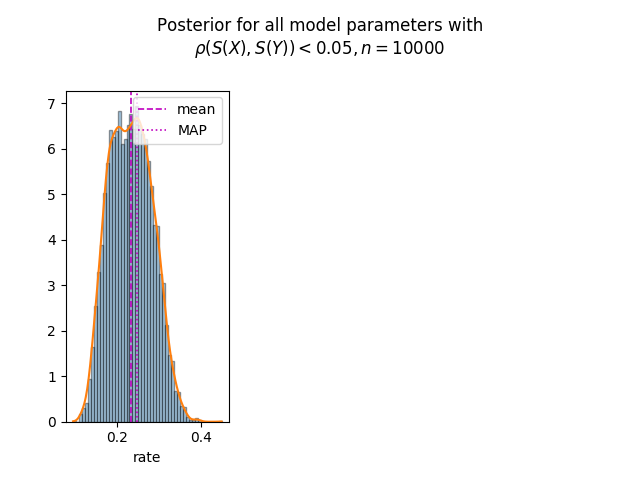

<IPython.core.display.Javascript object>


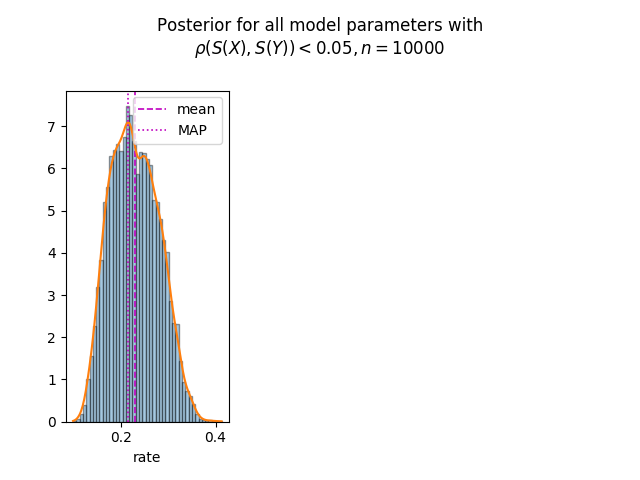

<IPython.core.display.Javascript object>


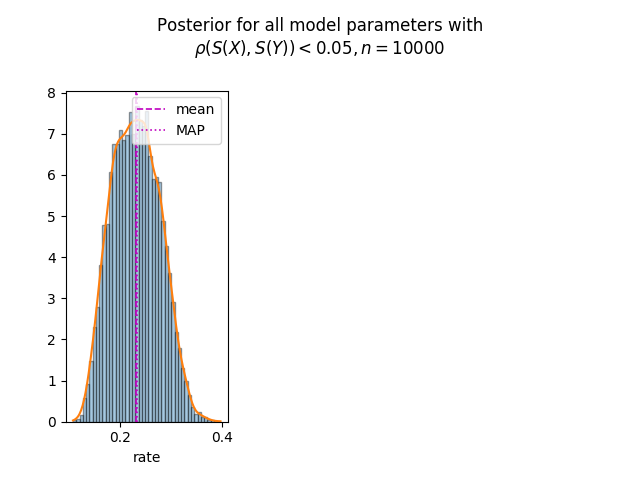

<IPython.core.display.Javascript object>


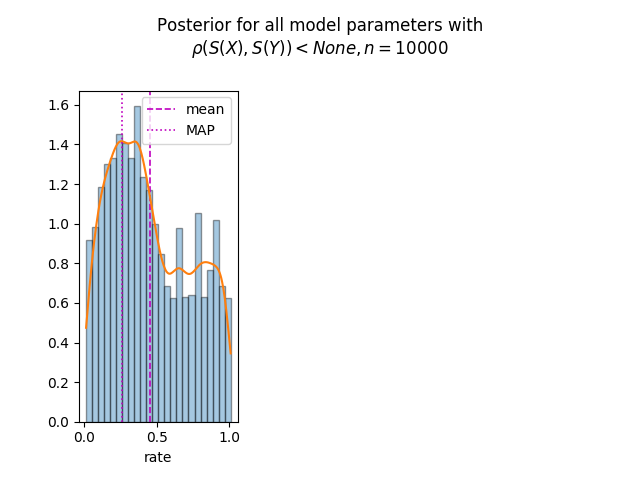

In [14]:
plot_marginals(rej, kde=True, normed=True)
plot_marginals(smc, kde=True, normed=True)
plot_marginals(mcmc, kde=True, normed=True)
plot_marginals(bolfi, kde=True, normed=True)

<IPython.core.display.Javascript object>


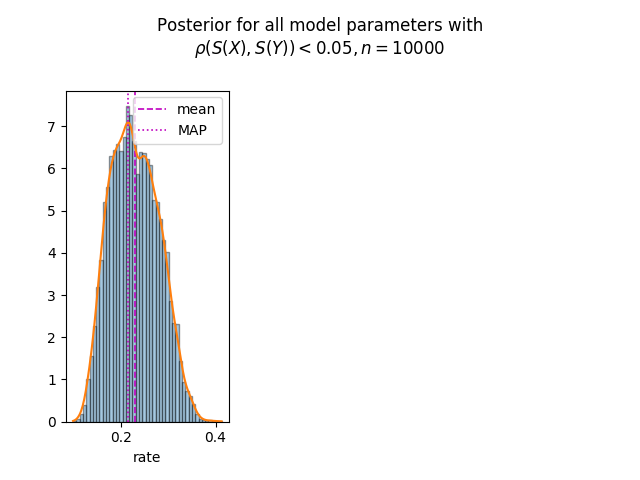

<IPython.core.display.Javascript object>


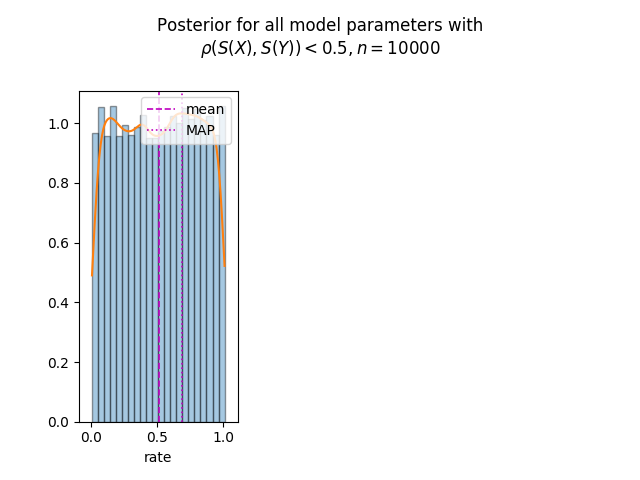

<IPython.core.display.Javascript object>


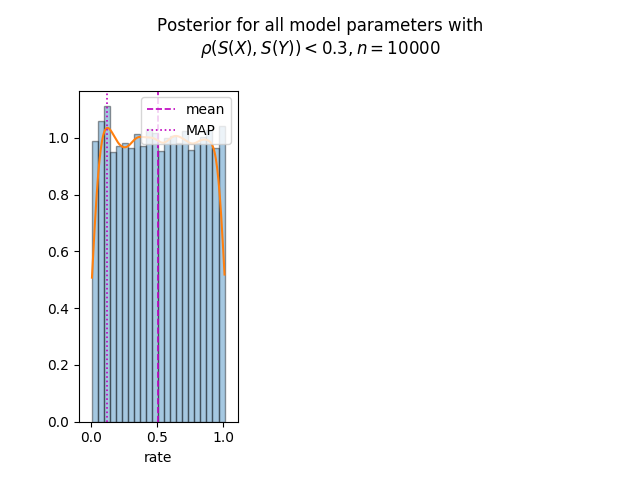

<IPython.core.display.Javascript object>


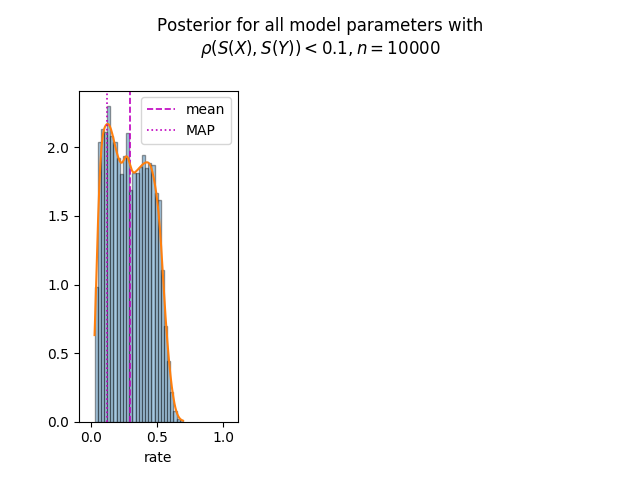

<IPython.core.display.Javascript object>


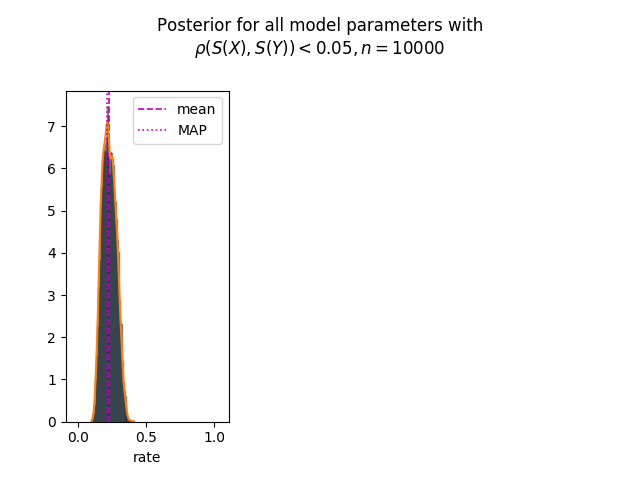

In [15]:
plot_marginals(smc, plot_all=True, normed=True, kde=True)

<IPython.core.display.Javascript object>


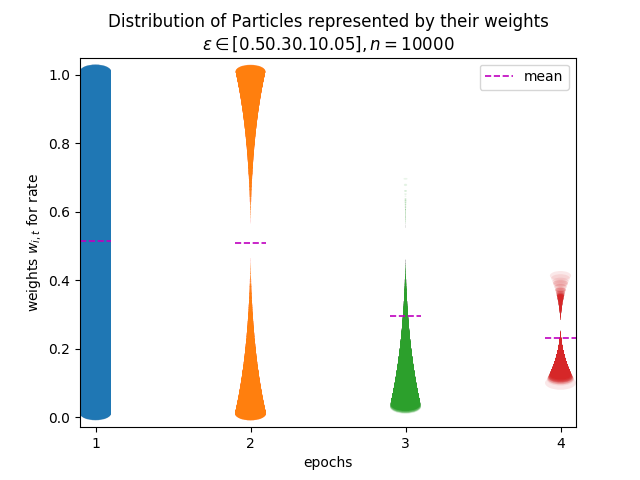

In [16]:
plot_particles(smc, equal_axes=False, alpha=0.1)

<IPython.core.display.Javascript object>


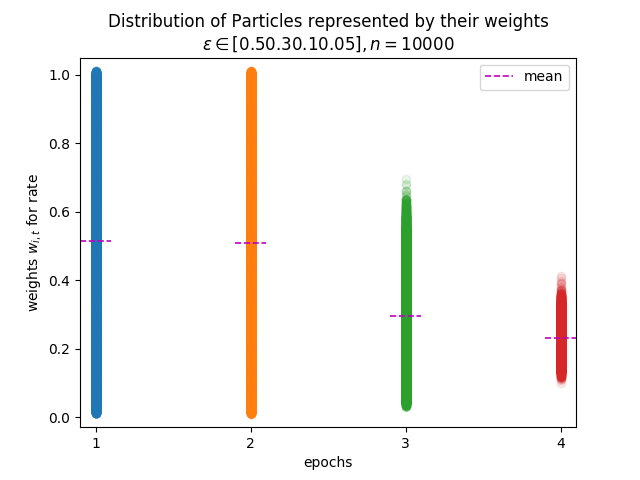

In [17]:
plot_particles(smc, as_circles=False, equal_axes=False, alpha=0.1)

<IPython.core.display.Javascript object>


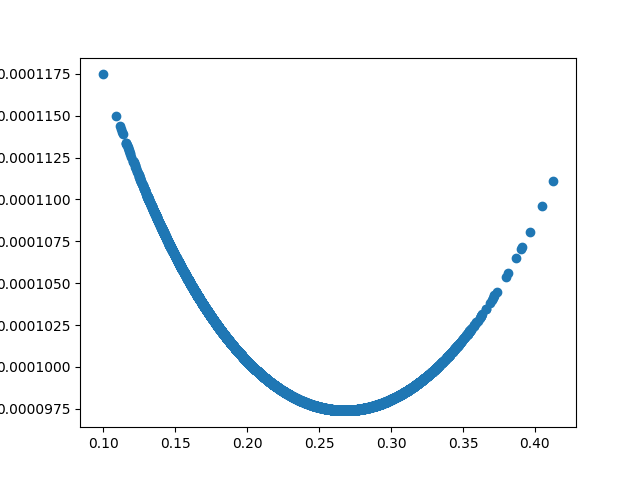

In [18]:
plt.figure()
plt.plot(smc.Thetas, smc.weights[-1], "o")